In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 12)
mpl.rc('axes',labelsize = 14, linewidth=1.25)
mpl.rc('xtick',labelsize = 14)
mpl.rc('ytick',labelsize = 14)
# enable math fonts
mpl.rc('mathtext', default = 'regular')


In [2]:
#https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/AJ/168/129/table5
planets = Table.read('sullivan2024_planets.vot').to_pandas()

# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/AJ/168/129/sample
stars = Table.read('sullivan2024_stars.vot').to_pandas() 

planets = planets.merge(stars, how='left', on='KOI')
planets['KOI'] = planets['KOI'].astype(int)

In [43]:
planets['kepoi_name'] = (
    'K' +
    planets['KOIpl'].astype(int).astype(str).str.zfill(5) +
    '.' +
    (planets['KOIpl'] % 1 * 100).round().astype(int).astype(str).str.zfill(2)
)

0      K00042.01
1      K00112.01
2      K00112.02
3      K00162.01
4      K00163.01
         ...    
399    K07835.01
400    K07842.01
401    K07940.01
402    K08077.01
403    K08253.01
Name: kepoi_name, Length: 404, dtype: object

In [44]:
kic = Table.read('/Users/enewton/DATA_DIR/kepler_dr3_good.fits').to_pandas()
kois = Table.read('/Users/enewton/DATA_DIR/nexscikois_2025.05.12_09.55.50.vot').to_pandas()
kois['kepid'] = kois['kepid'].astype('int64')
kois['KOI'] = kois['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)

kic = kois.merge(kic, how='left', on='kepid')


In [57]:
kois.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', 'KOI'],
      dtype='object')

In [45]:
db = planets.merge(kic, how='left', on='kepoi_name')


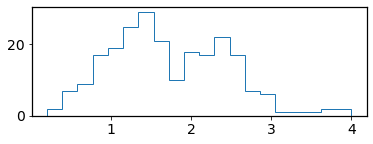

In [88]:
kois_less = kois[~kois['kepoi_name'].isin(db['kepoi_name'])]

kgood = (kois_less['koi_prad_err1']/kois_less['koi_prad'] < 0.05) & \
    (kois_less['koi_prad_err2']/kois_less['koi_prad'] < 0.05) & \
    (kois_less['koi_period'] < 100) 
plt.figure(figsize=(6,2))
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, histtype='step')
plt.show()

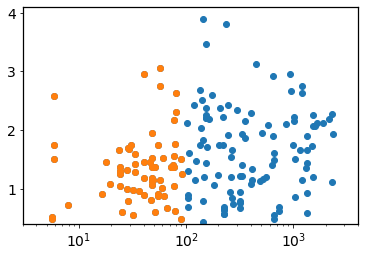

In [72]:
# trying to confirm this is right... 
# seems good, prob a bit dif b/c using different planet param database

db['distance'] = 1000./db['parallax']
db['SepAU'] = db['distance']*db['Sep']

good = (db['e_Rpkep']/db['Rpkep'] < 0.15) & (db['koi_period']<100)
close = db['SepAU']<100

plt.scatter(db['SepAU'][good], db['Rpkep'][good])
plt.scatter(db['SepAU'][good & close], db['Rpkep'][good & close])
plt.ylim(0.4,4.1)
plt.xlim(3, 4000)
plt.xscale('log')

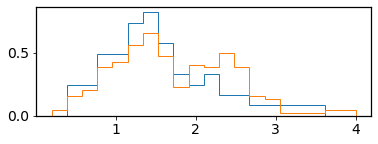

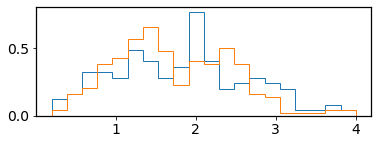

In [89]:
#kendall assumes they orbit primary stars which is prob mostly true based on nathanael's work?

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
plt.figure(figsize=(6,2))
plt.hist(db['Rppri'][good & close], range=[0.2,4], bins=20, 
         density=True, histtype='step')

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, 
         density=True, histtype='step')
plt.show()

plt.figure(figsize=(6,2))
plt.hist(db['Rppri'][good & ~close], range=[0.2,4], bins=20, 
         density=True, histtype='step')
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, 
         density=True, histtype='step')
plt.show()
